In [9]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from pypower import CatalogFFTPower, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix
sys.path.append('../bin')
from power_spectrum import select_region, get_rdd, naming, get_mean_poles
from mockfactory import Catalog, utils

plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

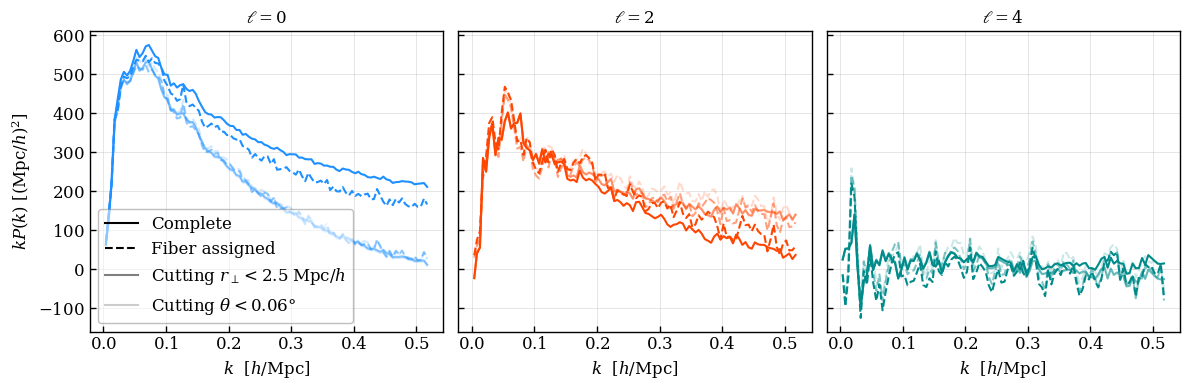

In [17]:
rpcut = 2.5
thetacut = 0.06
ells = (0, 2, 4)

data_type = "Y1secondgenmocks"

if data_type == "Y1firstgenmocks":
    data_dir = '/global/cfs/cdirs/desi/users/mpinon/power_spectra/'
    data_dir_new = '/global/cfs/cdirs/desi/users/mpinon/firstGenMocksY1/pk/'
    tracer = 'ELG'
    highres = False
    
if data_type == "Y1secondgenmocks":
    data_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/altmtl0/pk/'
    data_dir_new = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/altmtl0/pk/'
    tracer = 'ELG_LOPnotqso'
    highres = True

colors=['dodgerblue', 'orangered', 'darkcyan']

region = 'SGC'

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, ell in enumerate(ells):
    for ls, completeness in zip(['-', '--'], ['complete_', '']):
        powers = CatalogFFTPower.load(os.path.join(data_dir, naming(filetype="power", data_type=data_type, imock=0, tracer=tracer, completeness=completeness, region=region, rpcut=0, highres=highres)))
        powers_cut = CatalogFFTPower.load(os.path.join(data_dir, naming(filetype="power", data_type=data_type, imock=0, tracer=tracer, completeness=completeness, region=region, rpcut=rpcut, direct_edges=True, highres=highres)))
        powers_cut_theta = CatalogFFTPower.load(os.path.join(data_dir_new, naming(filetype="power", data_type=data_type, imock=0, tracer=tracer, completeness=completeness, region=region, thetacut=thetacut, direct_edges=True, highres=True)))
        #rebin = 5
        poles = powers.poles#.slice(slice(0, len(powers.poles.k)//rebin * rebin, rebin))
        k = poles.k
        axes[i].plot(k, k * poles(ell=ells, complex=False)[i], color=colors[i], ls=ls)
        axes[i].plot(powers_cut.poles.k, powers_cut.poles.k * powers_cut.poles(ell=ells, complex=False)[i], color=colors[i], ls=ls, alpha=0.5)
        axes[i].plot(powers_cut_theta.poles.k, powers_cut_theta.poles.k * powers_cut_theta.poles(ell=ells, complex=False)[i], color=colors[i], ls=ls, alpha=0.2)
    axes[i].set_title(r'$\ell={}$'.format(ell))

axes[0].plot([], [], ls='-', label='Complete', color='black')
axes[0].plot([], [], ls='--', label='Fiber assigned', color='black')
axes[0].plot([], [], ls='-', label='Cutting $r_{{\perp}} < {} \; \mathrm{{Mpc}}/h$'.format(rpcut), color='black', alpha=0.5)
#axes[1].plot([], [], ls='--', label=r'FA, cutting $r_{{\perp}} < {} \; \mathrm{{Mpc}}/h$'.format(rpcut), color='black', alpha=0.5)
axes[0].plot([], [], ls='-', label=r'Cutting $\theta < {}°$'.format(thetacut), color='black', alpha=0.2)
#axes[2].plot([], [], ls='--', label=r'FA, cutting $\theta < {}$'.format(thetacut), color='black', alpha=0.2)

axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
for i in range(len(ells)):
    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')
axes[0].legend()
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, 'pk_{}_{}_mock0{}_comparison_complete_fa_noimaging_rpcut_thetacut.png'.format(tracer, region, data_type)), dpi=300)
plt.show()

In [ ]:
nmocks = 1

poles_list = list()
std_list = list()
poles_list_cut = list()
std_list_cut= list()

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ls, completeness in zip(['--', '-'], ['', 'complete_']):
    powers = [CatalogFFTPower.load(os.path.join(data_dir, naming(filetype="power", data_type=data_type, imock=i, tracer=tracer, completeness=completeness, region=region, rpcut=0, highres=highres))) for i in range(nmocks)]
    powers_cut = [CatalogFFTPower.load(os.path.join(data_dir, naming(filetype="power", data_type=data_type, imock=i, tracer=tracer, completeness=completeness, region=region, rpcut=rpcut, direct_edges=True, highres=highres))) for i in range(nmocks)]

    rebin = 5
    poles, cov = get_mean_poles(powers, ells, rebin=rebin)
    poles_list.append(poles)
    #std = np.array(np.array_split(np.diag(cov)**0.5, len(ells)))/np.sqrt(nmocks)
    #std_list.append(std)

    poles_cut, cov_cut = get_mean_poles(powers_cut, ells)
    poles_list_cut.append(poles_cut)
    #std_cut = np.array(np.array_split(np.diag(cov_cut)**0.5, len(ells)))/np.sqrt(nmocks)
    #std_list_cut.append(std_cut)

for i in range(len(ells)):
    residual = (poles_list[0][i] - poles_list[1][i]) #/ std_list[1][i]
    axes[i].plot(powers[0].poles.k[:powers[0].poles.k.shape[0] // rebin * rebin:rebin], powers[0].poles.k[:powers[0].poles.k.shape[0] // rebin * rebin:rebin] * residual, color=colors[i], ls='-')

    residual_cut = (poles_list_cut[0][i] - poles_list_cut[1][i]) #/ std_list[1][i]
    axes[i].plot(powers_cut[0].poles.k, powers_cut[0].poles.k * residual_cut, color=colors[i], ls='-', alpha=0.5)
#    axes[i].fill_between(powers_tr[0].poles.k, powers_tr[0].poles.k * (- std_list_tr[0][i]), powers_tr[0].poles.k * (std_list_tr[0][i]), facecolor='grey', alpha=0.1)
    #axes[i].fill_between(powers[0].poles.k[:powers[0].poles.k.shape[0] // rebin * rebin:rebin], powers[0].poles.k[:powers[0].poles.k.shape[0] // rebin * rebin:rebin] * (- std_list[0][i]), powers[0].poles.k[:powers[0].poles.k.shape[0] // rebin * rebin:rebin] * (std_list[0][i]), facecolor='grey', alpha=0.1,
    #                    label=r'$ \sigma_\mathrm{{Y1}} /{:.0f}$'.format(np.sqrt(nmocks)))

    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')
    axes[i].set_title(r'$\ell={}$'.format(ells[i]))
    
axes[0].plot([], [], ls='-', label='No cut', color='black')
axes[0].plot([], [], ls='-', alpha=0.5, label=r'Cutting $r_{{\perp}}$ < {} Mpc/h'.format(rpcut), color='black')
axes[0].set_ylabel(r'$k \Delta P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend()
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, 'power_{}_FA-complete_SGC_ELG_rp_threshold.png'.format(data_type)))
plt.show()